In [22]:
# a bunch of import statements for the functions we'll be using
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.feature_selection import SelectKBest
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import re, string, codecs

# CUNEIF 102A
---
<img src="http://www.cleargoals.com/wp-content/uploads/2017/04/data-science-methods-and-algorithms-for-big-data.jpg" style="width: 500px; height: 275px;" />

### Professor Veldhuis

A brief description of the notebook and how it fits into the overall module and domain.

*Estimated Time: X minutes*

---

### Topics Covered
- Clustering Documents: Using K-means Clustering
- Multidimensional Scaling (MDS): Visualizing the Data


### Table of Contents

1 - [Section 1: Clustering Documents](#section 1)<br>

2 - [Section 2: Multidimensional Scaling](#section 2)<br>


**Dependencies:**

---
## Section 1: Clustering Documents<a id='section 1'></a>


# Clustering Documents #

Clustering is the grouping of a particular set of objects based on their characteristics, grouping them according to their similarities so that "objects in the same group (called a cluster) are more similar (in some sense or another) to each other than to those in other groups (clusters)." (Learn more: https://en.wikipedia.org/wiki/Cluster_analysis)

### Reading in the DTM ###
First we'll read in the DTM (Document Term Matrix) from a CSV (comma-separated values) file. We're using a DTM that has been cleaned of all stopwords and normalized.

The first line of the csv consists of a list of all the words, and the first column of the csv has all the text names, so we'll load those in first. Below I use the file path 'Data/stop11tfidf1gram.csv', but if you want to try out different DTMs (all of them can be found in the Data folder) you can replace the filepath with your chosen file name. All file paths should be of the form 'Data/[name of doc here].csv'.

In [23]:
filepath = 'Data/onegramfilteredtfidf.csv' #this is where the dtm is stored

First let's generate a list of words and texts present in the DTM. The list of words is just the first row of the DTM (the column names). The list of document IDs is the first column of each row (the row names).

In [24]:
words = None
texts = []
with open(filepath, 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for line in reader:
        if words is None:
            words = line[1:] #this will only be run on the first iteration of the loop
        else:
            texts.append(line[0]) #text names are the first entry of each row
words = [re.sub('[^\w\[\]\-/]','', word) for word in words] #clean the words of bad characters

In [25]:
print(words[:10]) #print out the first 10 words as a sanity check
print(len(words)) #see how many words there are

['1-kam-ma[1st]NU', '1/2[1/2]NU', '1/3[1/3]NU', '10-kam-ma[10th]NU', '1000[1000]NU', '100[100]NU', '108000[108000]NU', '1080[1080]NU', '108[108]NU', '10[10]NU']
4302


In [26]:
print(texts[:10]) #print out the first 10 document IDs as a sanity check
print(len(texts))

['c.0.1.1', 'c.0.1.2', 'c.0.2.01', 'c.0.2.02', 'c.0.2.03', 'c.0.2.04', 'c.0.2.06', 'c.0.2.07', 'c.0.2.08', 'c.0.2.11']
356


I'll also define a function to access document names based on indices. This will come in handy later.

In [27]:
def id_text(index):
    return texts[index]

I'll also define a dictionary, and function that maps the document ID's (like c.0.1.1) to document names (like 'Ur III catalogue from Nibru (N1)').

In [28]:
idToTextName = {}
with codecs.open('Data/idToTextName.csv', 'r', encoding='utf-8') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for line in reader:
        if len(line) == 2:
            idToTextName[line[0]] = re.sub('[^\w\[\]\-/]','', line[1])

In [29]:
def text_name(doc):
    if(type(doc) == int): #if an index was passed in, turn it into a doc ID
        doc = id_text(doc)
    try:
        return idToTextName[doc] #not all document labels will be in the dictionary
    except:
        return doc #if not in the dictionary, just return the argument passed in

Now we read in the rest of the DTM using the loadtxt function provided by NumPy.

In [30]:
dtm = np.loadtxt(filepath, delimiter=',', skiprows=1, converters = {0: lambda s: 0})
dtm = np.delete(dtm, 0, 1) #delete the first row (it only has document names and not tf-idf values)

We now try to cluster documents that are similar to each other.

### K-Means Clustering ###

[K-Means clustering](https://en.wikipedia.org/wiki/K-means_clustering) is an iterative method to group vectors into $k$ clusters. It uses the following process:

1. Randomize $k$ "cluster centers". These are preliminary estimates for where the clusters are going to be centered.
2. Categorize each data point by which cluster center it's closest to. We should now have $k$ clusters, each vector belonging to a single cluster.
3. Redefine each cluster center at the actual center of the vectors that were assigned to it in step 2.
4. Repeat steps 2 and 3 until convergence (until the cluster centers aren't changing by much anymore).

To see this process visually, consider the following two-dimensional dataset (our actual dataset is more like 4000+ dimensions, one dimension for each term):

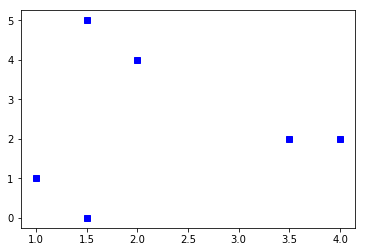

In [92]:
xs = [1, 1.5, 1.5, 2, 3.5, 4]
ys = [1, 0.0, 5, 4, 2, 2]
plt.plot(xs, ys, 'bs')
plt.show()

Let's say we want three clusters. First we initialize random cluster centers (in red):

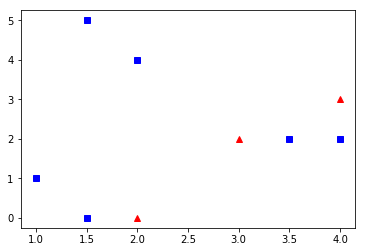

In [93]:
cxs = [2, 3, 4]
cys = [0, 2, 3]
plt.plot(xs, ys, 'bs')
plt.plot(cxs, cys, 'r^')
plt.show()

We now assign each data point (or vector) to the nearest cluster center.

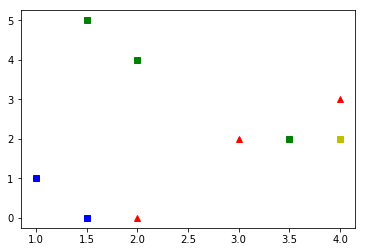

In [94]:
plt.plot(xs[:2], ys[:2], 'bs')
plt.plot(xs[2:5], ys[2:5], 'gs')
plt.plot(xs[5:], ys[5:], 'ys')
plt.plot(cxs, cys, 'r^')
plt.show()

Here I've colored the ones closest to the (2, 0) cluster in blue, the ones closest to the (3, 2) cluster in green, and the ones closest to the (4, 3) cluster in yellow.

Now we recenter all the cluster centers at the actual centers of the current clusters

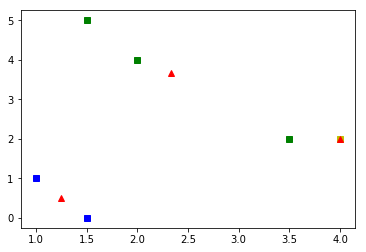

In [95]:
cxs = [1.25, 7/3, 4]
cys = [.5, 11/3, 2]
plt.plot(xs[:2], ys[:2], 'bs')
plt.plot(xs[2:5], ys[2:5], 'gs')
plt.plot(xs[5:], ys[5:], 'ys')
plt.plot(cxs, cys, 'r^')
plt.show()

If we repeat the above process (assign vectors to closest centers, then re-define centers) one more time, we will end up with the below clustering.

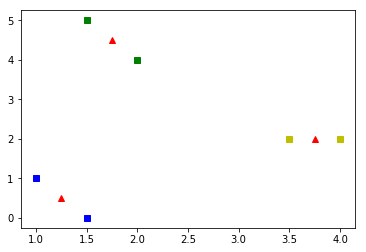

In [96]:
cxs = [1.25, 1.75, 3.75]
cys = [.5, 4.5, 2]
plt.plot(xs[:2], ys[:2], 'bs')
plt.plot(xs[2:4], ys[2:4], 'gs')
plt.plot(xs[4:], ys[4:], 'ys')
plt.plot(cxs, cys, 'r^')
plt.show()

Looks about right! Even though this time it only took two iterations, usually this will take many many iterations to get right. Furthermore, since the initial cluster centers are randomized, and our dataset doesn't have extremely clear clusters like in this example, we will end up with different clusterings every time we run k-means on it.

#### Using K-Means Clustering for the Corpus

Let's try executing K-Means on our documents using 7 clusters. I picked 7 arbitrarily - in the future we can try using the "[elbow method](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set#The_elbow_method)" to determine a number of clusters, or we can try different options and manually inspect the clusters to see if they make any sense.

We use scikit-learns convenient KMeans function; it does all the work for us, we just have to specify number of clusters.

In [97]:
dtm_normalized_kmeans = KMeans(n_clusters=7, max_iter=1000).fit(dtm)

We can examine the "label" of each of the documents as defined by this clustering - this tells us which cluster each of the documents is classified under.

In [98]:
labels = dtm_normalized_kmeans.labels_
labels

array([6, 1, 6, 1, 6, 6, 6, 2, 6, 1, 6, 6, 6, 1, 6, 2, 6, 6, 6, 6, 6, 6, 6,
       6, 2, 6, 6, 6, 0, 0, 0, 6, 2, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 5, 5, 5, 5, 5, 5, 5, 6,
       6, 6, 6, 6, 6, 1, 2, 6, 1, 1, 1, 0, 1, 1, 6, 6, 2, 2, 6, 6, 2, 2, 2,
       0, 1, 1, 1, 1, 1, 1, 1, 6, 6, 1, 1, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 6,
       6, 6, 1, 0, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 6, 1, 6, 6, 1, 1, 6, 1, 1, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1,
       6, 6, 1, 1, 6, 1, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4,
       4, 4, 4, 6, 4, 4, 4, 6, 6, 3, 6, 4, 4, 6, 6, 6, 6, 6, 1, 6, 1, 6, 1,
       1, 6, 6, 1, 6, 6, 6, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 6, 2, 2, 6, 6, 6,
       2, 2, 6, 3, 2, 2, 2, 6, 2, 6, 2, 6, 6, 1, 1, 6, 2, 1, 6, 1, 6, 6, 1,
       6, 1, 2, 1, 6, 6, 6, 6, 1, 6, 6, 6, 1, 1, 6, 6, 6, 6, 6, 6, 1, 1, 6,
       1, 1, 1, 6, 1, 6, 6, 6, 0, 0, 0, 0, 6, 0, 6, 1, 1, 6, 6, 2, 2, 1, 6,
       1, 6,

It seems like a there is a nice spread of documents being assigned to different clusters. (what we don't want is something like 50% or more of the documents falling into the same cluster).

Let's see what the centers of each of the clusters look like.

In [99]:
cluster_centers = dtm_normalized_kmeans.cluster_centers_
cluster_centers

array([[  0.00000000e+00,   0.00000000e+00,   1.08420217e-19, ...,
          2.16840434e-19,   2.39968072e-03,  -5.42101086e-20],
       [  6.83903017e-04,   1.01411992e-04,   1.08420217e-19, ...,
          5.42101086e-19,   6.50521303e-19,  -1.62630326e-19],
       [  2.66345430e-03,   1.64478884e-03,   1.08420217e-19, ...,
         -2.16840434e-19,  -1.08420217e-19,   5.42101086e-20],
       ..., 
       [  2.44743356e-03,   1.73472348e-18,   1.08420217e-19, ...,
          2.16840434e-19,  -5.42101086e-20,  -5.42101086e-20],
       [  0.00000000e+00,   0.00000000e+00,   1.08420217e-19, ...,
          0.00000000e+00,  -5.42101086e-20,  -2.71050543e-20],
       [  3.65686643e-03,   6.36708708e-03,   1.44334312e-03, ...,
          1.16435526e-03,   5.86011032e-04,   3.59127150e-04]])

Interesting... We get a nice variation across cluster centers (i.e. not all 0s or anything like that), so we can move on.


Below I now define a method that takes in a cluster number, and outputs a dictionary whose values are lists of documents that belong to a specific cluster. The idea is that someone familiar with this corpus could look at the output and determine if the clustering makes any sense whatsoever.

In [100]:
def inspect_clusters(num_clusters):
    km = KMeans(n_clusters=num_clusters, max_iter=1000).fit(dtm)
    labels = km.labels_
    clusters = {}
    for i in range(num_clusters):
        docs = [j for j in range(len(labels)) if labels[j] == i]
        clusters[i] = [id_text(k) for k in docs]
    return clusters

Here's an example of a use of this function. This examines the documents that appear in a certain cluster given that we choose $k = 7$.

In [101]:
seven_clusters = inspect_clusters(7)

In [102]:
print(seven_clusters[0])

['c.5.5.2', 'c.6.1.12', 'c.6.1.13', 'c.6.1.27']


In [103]:
print(seven_clusters[1])

['c.1.2.2', 'c.1.3.2', 'c.1.3.5', 'c.1.7.4', 'c.1.8.1.1', 'c.2.1.4', 'c.2.1.6', 'c.2.1.7', 'c.2.2.2', 'c.2.2.3', 'c.2.2.4', 'c.2.2.5', 'c.2.2.6', 'c.2.3.1', 'c.2.3.2', 'c.2.4.1.1', 'c.2.4.1.2', 'c.2.4.1.3', 'c.2.4.1.5', 'c.2.4.1.6', 'c.2.4.1.a', 'c.2.4.2.01', 'c.2.4.2.02', 'c.2.4.2.03', 'c.2.4.2.04', 'c.2.4.2.05', 'c.2.4.2.07', 'c.2.4.2.15', 'c.2.4.2.16', 'c.2.4.2.17', 'c.2.4.2.18', 'c.2.4.2.22', 'c.2.4.2.24', 'c.2.4.2.25', 'c.2.4.2.b', 'c.2.4.4.a', 'c.2.5.1.2', 'c.2.5.1.3', 'c.2.5.1.4', 'c.2.5.3.1', 'c.2.5.3.2', 'c.2.5.3.4', 'c.2.5.4.01', 'c.2.5.4.11', 'c.2.5.4.a', 'c.2.5.5.1', 'c.2.5.5.2', 'c.2.5.8.1', 'c.2.6.6.1', 'c.2.6.7.1', 'c.2.6.9.1', 'c.2.6.9.4', 'c.2.6.9.5', 'c.2.6.9.6', 'c.2.6.9.7', 'c.2.6.9.8', 'c.2.7.1.1', 'c.2.8.2.1', 'c.2.8.2.4', 'c.2.8.3.2', 'c.2.8.3.5', 'c.2.8.3.6', 'c.2.8.5.a', 'c.2.8.5.b', 'c.3.2.05', 'c.3.3.01', 'c.3.3.09', 'c.3.3.10', 'c.3.3.21', 'c.3.3.22', 'c.3.3.39', 'c.4.02.1', 'c.4.05.1', 'c.4.07.2', 'c.4.07.3', 'c.4.07.4', 'c.4.07.5', 'c.4.07.a', 'c.4.12.1', 

In [104]:
print(seven_clusters[2])

['c.0.1.2', 'c.1.6.1', 'c.1.6.2', 'c.1.6.3', 'c.2.4.2.20', 'c.2.4.2.21', 'c.2.4.4.4', 'c.2.5.2.1', 'c.2.5.3.3', 'c.2.5.4.09', 'c.2.5.4.15', 'c.2.5.5.4', 'c.2.5.6.3', 'c.2.5.7.1', 'c.4.07.1', 'c.4.15.2', 'c.4.15.3', 'c.4.19.2', 'c.4.19.3', 'c.4.27.01', 'c.4.27.02', 'c.4.27.03', 'c.4.27.04', 'c.4.27.07', 'c.4.31.1', 'c.4.80.2', 'c.4.80.4']


Save clusters into variables (used later in the MDS Section)

In [109]:
cluster_0 = seven_clusters[0]
cluster_1 = seven_clusters[1]
cluster_2 = seven_clusters[2]
cluster_3 = seven_clusters[3]
cluster_4 = seven_clusters[4]
cluster_5 = seven_clusters[5]
cluster_6 = seven_clusters[6]

We see a high frequency of documents belonging in a specific "genre" (like c.2) per cluster, so perhaps we're onto something by choosing 7 clusters?

And finally, below I define a method to classify a new text into one of the seven clusters. It does this by finding which of the cluster centers is closest (in terms of Euclidean distance) to the new text vector.

In [110]:
def classify(cluster_centers, new_text):
    euclid_dist = lambda x, y: np.linalg.norm(x-y)
    return min(range(len(cluster_centers)), \
                     key=lambda i: euclid_dist(cluster_centers[i], new_text))

If we test this function using the cluster centers we just generated with seven clusters, and passing in the second document of our existing corpus as a "new text", we see that our classifier correctly chooses the category k-means had chosen previously.

In [111]:
classify(cluster_centers, dtm[1])

1

### K-Means Visualization ###
It's difficult to visualize the clustering of 4000+ dimension vectors (each term  adds to the dimensionality of the vecotrs).

Here we attempt to use feature selection - trying to pick out two or three of the most "significant" features (where features are terms in this case) and plot those features onto 2D or 3D graphs. Below we try two different selection criteria to determine which terms to plot.

This one sees which word has the highest tf-idf values across the clusters we choose to plot.

In [112]:
# gives the features with the largest magnitude (summed across given cluster centers)
def largest_selector(clusters, num_features):
    size = []
    for feat in range(len(clusters[0])):
        size.append((feat, sum([c[feat] for c in clusters])))
    size = sorted(size, key=lambda t: -t[1]) 
    return size[:num_features]

This one sees which word has the highest difference across tf-idf values across the clusters we choose to plot.

In [113]:
# gives the features with the largest difference between clusters
def largest_diff_selector(clusters, num_features):
    tot_diff = []
    for feat in range(len(clusters[0])):
        tot_diff.append((feat, sum([abs(c1[feat] - c2[feat]) for c1 in clusters for c2 in clusters])))
    tot_diff = sorted(tot_diff, key=lambda t: -t[1])
    return tot_diff[:num_features]

Below I've defined two functions that take in a list of cluster numbers, a selector function (one of the two just defined above, and a new text - a text that is not yet in the corpus that we want to compare.

Each of these functions will use matplotlib to plot a scatterplot of the clusters selected (in different colors) according to the frequency of the terms that were selected by the selector function. They will also print out the terms that were selected.

Don't worry too much about how these functions work. We'll go through a couple examples below.

In [114]:
colors = iter(['bs', 'ys', 'gs'])
colors = iter(colors)
next(colors)

'bs'

In [115]:
def plot2d(clusters, selector_func, new_text=None):
    selected_features = selector_func([cluster_centers[i] for i in clusters], 2)
    selected_features = [f[0] for f in selected_features]
    
    selected_dtm = dtm[:,selected_features]
    mask = lambda i: [lbl == i for lbl in labels]
    cluster_vectors = [selected_dtm[mask(i)] for i in clusters]
    colors = iter(['bs', 'ys', 'gs', 'cs'])
    cluster_numbers = iter(clusters)
    for cluster in cluster_vectors:
        X, Y = zip(*cluster)
        plt.plot(X, Y, next(colors), label="cluster " + str(next(cluster_numbers)))
    if new_text is not None:
        plt.plot(new_text[selected_features[0]], new_text[selected_features[1]], 'r^', label="new text")
    plt.legend()
    plt.xlabel(words[selected_features[0]])
    plt.ylabel(words[selected_features[1]])
    plt.show()
    return selected_features
    
def plot3d(clusters, selector_func, new_text=None):
    selected_features = selector_func([cluster_centers[i] for i in clusters], 3)
    selected_features = [f[0] for f in selected_features]
    
    selected_dtm = dtm[:,selected_features]
    mask = lambda i: [lbl == i for lbl in labels]
    cluster_vectors = [selected_dtm[mask(i)] for i in clusters]
    cluster_numbers = iter(clusters)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for cluster in cluster_vectors:
        X, Y, Z = zip(*cluster)
        ax.scatter(X, Y, Z, label="cluster " + str(next(cluster_numbers)))
    if new_text is not None:
        X, Y, Z = new_text[selected_features[0]], new_text[selected_features[1]], new_text[selected_features[2]]
        ax.scatter(X, Y, Z, label="new text")
    plt.legend()
    plt.xlabel(words[selected_features[0]])
    plt.ylabel(words[selected_features[1]])
    ax.set_zlabel(words[selected_features[2]])
    plt.draw()
    plt.show()
    return selected_features

Let's try using these functions now. First, 2D.

Below I pass in [0, 1] as clusters (meaning we want to visualize the documents in the 0th and 1st cluster). We are using the largest_selector function to pick out two features.

/Users/stephkim/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


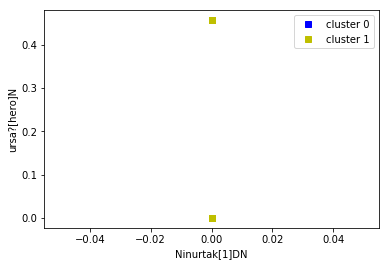

In [116]:
selected = plot2d([0, 1], largest_selector)

We can see that cluster0 (in blue) has greater variation across the x-axis, or the term  'Ninurtak[1]DN', whereas cluster1 (in yellow) has more variation across the y-axis, the term 'ursa?[hero]N'. 

Let's try passing in the exact same thing, but also add in a "new text". Let's treat the second document of the DTM as our new text for now.

/Users/stephkim/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


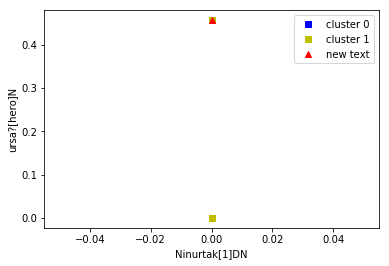

In [117]:
selected = plot2d([0, 1], largest_selector, new_text=dtm[1])

Our "new text", marked in red, seems pretty far from the others documents in the two clusters, so we might predict that it doesn't fall into either of the clusters we've chosen to visualize.

Let's try passing in the exact same paramenters into the 3D function.

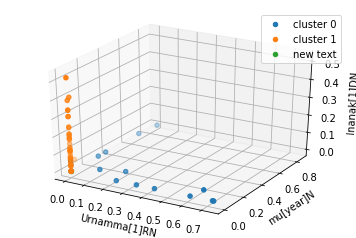

In [31]:
selected = plot3d([0, 1], largest_selector, new_text=dtm[1])

We see the same results as before, except we now see that cluster1 (in orange) has variation across the third term our selector chose, 'Inanak[1]DN', whereas cluster0 and our new_text (in green) seem to not vary across this third term much.

We can also throw in more clusters (than two) into the function. Here I call the same function, but also include cluster3.

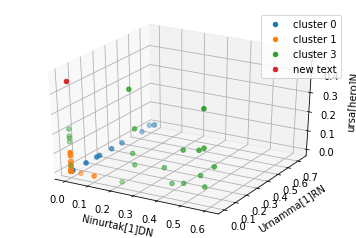

In [32]:
selected = plot3d([0, 1, 3], largest_selector, new_text=dtm[1])

Here we see that cluster3 (green), like cluster1 (orange), doesn't vary much in the x-axis, though it does have more variation in the y-axis than cluster1. Our new text still doesn't look like it fits any of these too well.

If you look at labels up above, we could see that it's actually classified into cluster3. One might have been able to guess this? - it has a larger y-value (like cluster0 and cluster3), but a 0 x-value (unlike cluster0).


Below I write out a couple other usages of these functions. See if you can explain in words what they are visualizing, and what the differences between the clusters seem to be.

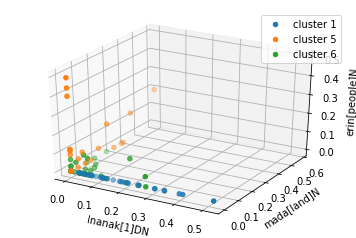

In [33]:
selected = plot3d([1, 5, 6], largest_diff_selector)

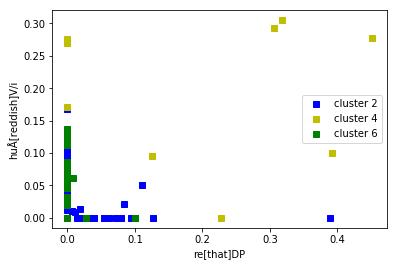

In [34]:
selected = plot2d([2, 4, 6], largest_diff_selector)

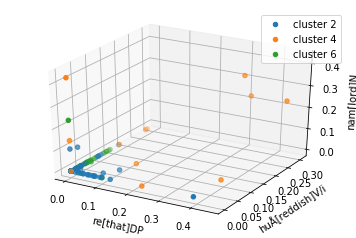

In [35]:
selected = plot3d([2, 4, 6], largest_diff_selector)

### Hierarchical Clustering ###
We'll use "agglomerative clustering" here, a variant of hierarchical clustering.

In agglomerative clustering, each document starts as a cluster.
The algorithm will look for which clusters are most similar and will pair them up ("link" them) to form a new cluster. Now we have one fewer clusters (because two clusters just became one). This keeps happening until *all* the documents are part of a single cluster.



In [36]:
dtm_normalized_hierarchical = AgglomerativeClustering(7).fit(dtm)

We can check the number of "leaves" as a sanity check. This should equal the number of documents.

In [37]:
dtm_normalized_hierarchical.n_leaves_

356

We can also check the labels of each document. Like with k-means, this represents which cluster this method would place each document in.

In [38]:
hierarchical_labels = dtm_normalized_hierarchical.labels_
hierarchical_labels

array([1, 4, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 4, 4, 4, 1, 4, 4, 4, 4, 1, 4, 4,
       1, 1, 1, 1, 1, 5, 5, 4, 1, 1, 4, 1, 1, 1, 4, 4, 4, 1, 4, 4, 4, 4, 4,
       4, 0, 0, 1, 1, 3, 1, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 1, 0, 0, 0, 0,
       4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 5, 4, 4, 4, 4, 1, 1, 0, 0, 1, 1, 1,
       5, 0, 0, 0, 4, 0, 0, 0, 6, 1, 2, 4, 4, 1, 1, 2, 4, 2, 2, 2, 2, 2, 4,
       1, 4, 2, 5, 2, 4, 2, 2, 4, 4, 2, 1, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2,
       4, 5, 4, 4, 0, 0, 4, 4, 4, 0, 4, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6,
       6, 6, 6, 3, 1, 1, 6, 4, 1, 3, 3, 1, 1, 1, 4, 1, 1, 1, 4, 4, 4, 4, 4,
       4, 1, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 4, 4, 4, 1, 0, 1, 1, 1, 1, 2, 1,
       2, 2, 2, 1, 2, 1, 1, 1, 5, 5, 5, 5, 1, 4, 4, 2, 2, 4, 1, 1, 1, 2, 1,
       4, 1,

Like with k-means, we see that there is a fair amount of variation in the labels.

We can also look at the "children" attribute. This tells us how the documents were linked together.

In [39]:
children = dtm_normalized_hierarchical.children_
children[:10]

array([[115, 242],
       [ 65,  66],
       [ 41,  42],
       [  2,   3],
       [133, 137],
       [ 93,  94],
       [  5, 359],
       [128, 129],
       [ 28,  29],
       [ 59,  60]], dtype=int64)

The first pair of the array indicates which two documents were linked together first. For example, if the array looked like what's below:

In [40]:
np.array([[115, 242], [65,  66], [41,  42], [2, 3], [133, 137]])

array([[115, 242],
       [ 65,  66],
       [ 41,  42],
       [  2,   3],
       [133, 137]])

This would mean that documents 115 and 242 were linked together first, followed by documents 65 and 66, etc.

Note that this means the children array should have length one less than the total number of documents. Think about why this is.

### Hierarchical Visualization ###
Let's draw a dendrogram! Here we're going to use scipy's function.

First we go through the agglomerative proceess (called "linkage").

In [41]:
Z = linkage(dtm)

And now we plot all the documents in a dendrogram. A dengrogram looks has a tree structure, meaning that it starts with a root, and splits off into more and more "branches", which then keep splitting until we reach "leaves", which in this case are documents. Leaves on the same branch as "similar" to each other as decided by the linkage function.

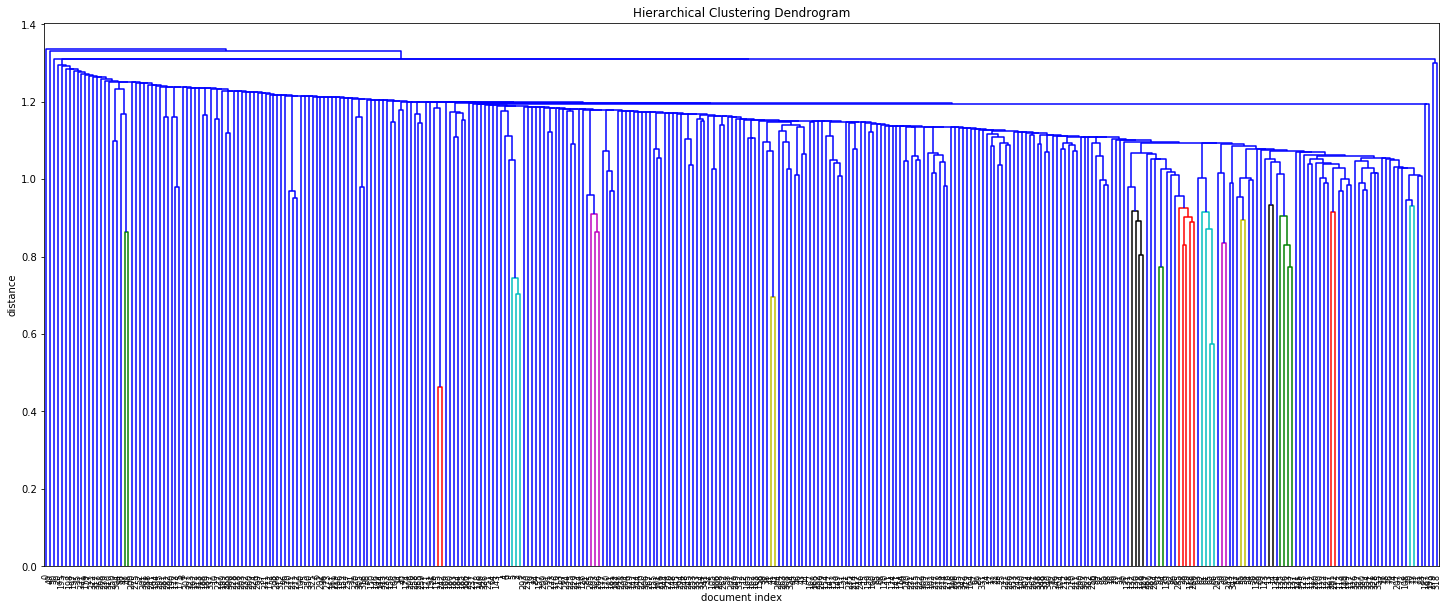

In [42]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('document index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

This is way too crowded, since it has all 394 documents. Let's try it on some subset of the documents - maybe the ones from a specific cluster.

So first we select only the documents from cluster 0.

In [43]:
# select only documents from one of the clusters
mask = [i for i in range(len(hierarchical_labels)) if hierarchical_labels[i] == 2]
dendro_labels = [text_name(i) for i in mask]
selected_hierarchical = dtm[mask]

In [44]:
len(selected_hierarchical)

30

Then we go through the agglomerative process.

In [45]:
Z2 = linkage(selected_hierarchical)

And now we plot!

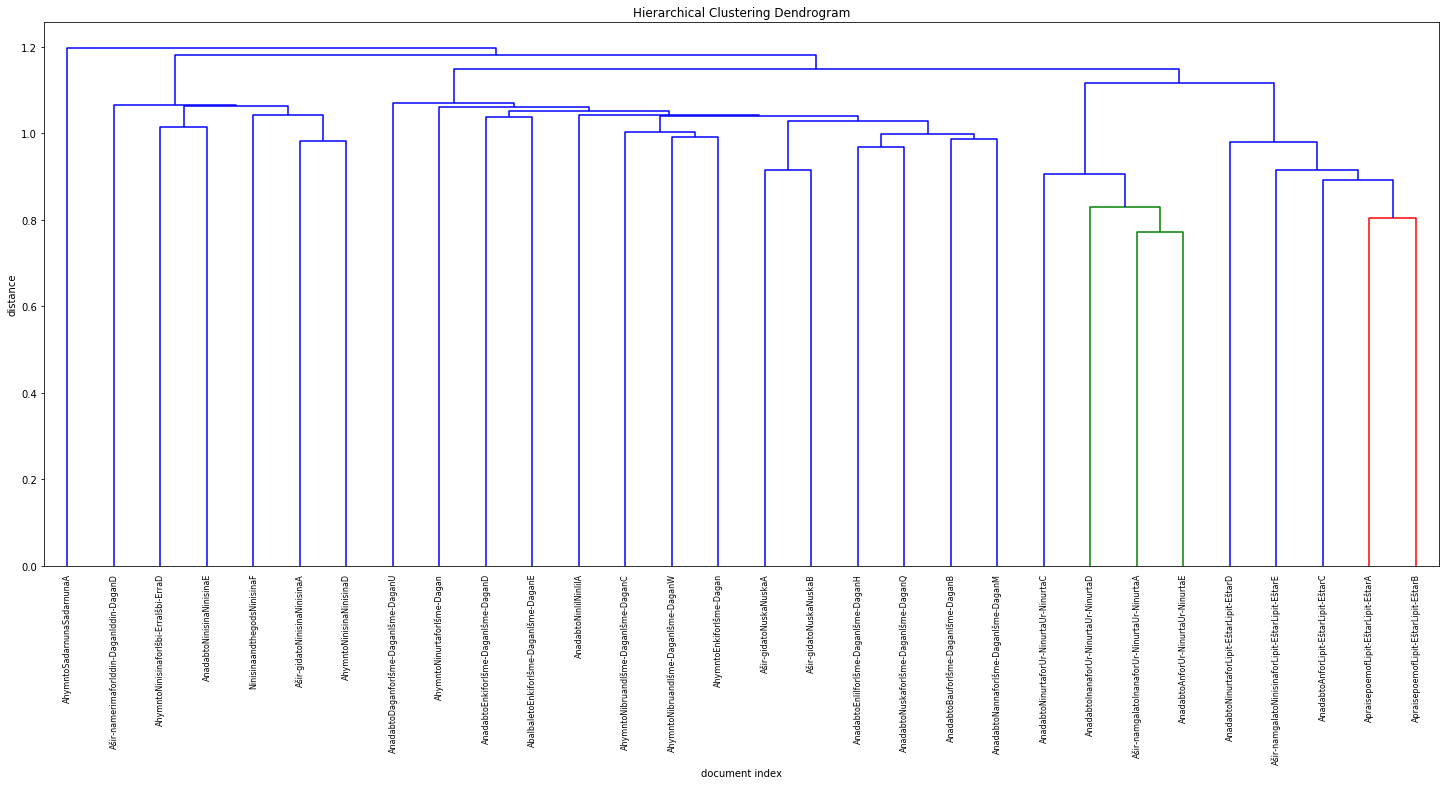

In [46]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('document index')
plt.ylabel('distance')
dendrogram(
    Z2,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    labels=dendro_labels
)
plt.show()

We can now clearly see (if we go from bottom up) the progression in which the documents were linked together. For example, documents 10 and 11 (near the right) were linked together pretty early (meaning they were deemed relatively "similar"), this new "cluster" was then linked with document 7, then 8, then 9.

---
## Section 2: Multidimensional Scaling<a id='section 2'></a>

## MDS 
Multidimensional scaling (MDS) is similar to factor analysis, which reduces the number of variables one has to work with and detects structure and patterns in the relationships between variables. It helps classify variables. The end goal is to analyze and be able to find a group of variables that results in clear similarities and dissimilarities (distances) between the objects using the variables that best describe them. “In factor analysis, the similarities between objects (e.g., variables) are expressed in the correlation matrix. With MDS, you can analyze any kind of similarity or dissimilarity matrix, in addition to correlation matrices.” (More information: http://www.statsoft.com/Textbook/Principal-Components-Factor-Analysis and http://scikit-learn.org/stable/modules/manifold.html#multidimensional-scaling)


A simple example of MDS is a map of cities. We can use 2 dimensions to describe the location of the cities. MDS arranges the objects (cities) in a particular dimension (2-D) to demonstrate the observed differences. “As a result, we can "explain" the distances in terms of underlying dimensions; in our example, we could explain the distances in terms of the two geographical dimensions: north/south and east/west.” (More information: http://www.statsoft.com/Textbook/Principal-Components-Factor-Analysis and http://scikit-learn.org/stable/modules/manifold.html#multidimensional-scaling)

In [1]:
!pip install datascience

#a bunch of import statements for the functions we'll be using
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.feature_selection import SelectKBest
import numpy as np
import csv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### Read and process the file and data (Do not worry too much about the code used)

In [121]:
file = open('Data/onegramfilteredtfidf.csv', 'r') 
file

<_io.TextIOWrapper name='Data/onegramfilteredtfidf.csv' mode='r' encoding='UTF-8'>

In [122]:
first = True
texts = []
with open('Data/onegramfilteredtfidf.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for line in reader:
        if(first):
            words = line
            first = False
        else:
            texts.append(line[0])
words = words[1:]

In [123]:
print(words[:10]) #print out the first 10 words as a sanity check
print(len(words))

['1-kam-ma[1st]NU', '1/2[1/2]NU', '1/3[1/3]NU', '10-kam-ma[10th]NU', '1000[1000]NU', '100[100]NU', '108000[108000]NU', '1080[1080]NU', '108[108]NU', '10[10]NU']
4302


In [124]:
def doc_name(index):
    return texts[index]

In [125]:
erikcsv = open('Data/onegramfilteredtfidf.csv', 'r') 
dtm = np.loadtxt(erikcsv, delimiter=',', skiprows=1, converters = {0: lambda s: 0})
dtm = np.delete(dtm, 0, 1)
dtm

array([[ 0.22870994,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [126]:
len(dtm) #size of dtm

356

### Compare each text to all other texts using the cosine distance.

In [127]:
import numpy as np
from datascience import *

from sklearn.feature_extraction.text import CountVectorizer
#import pandas as pd
from sklearn.metrics import pairwise

dist_matrix = pairwise.pairwise_distances(dtm, metric='cosine') 
Table(texts).with_rows(dist_matrix)

c.0.1.1,c.0.1.2,c.0.2.01,c.0.2.02,c.0.2.03,c.0.2.04,c.0.2.06,c.0.2.07,c.0.2.08,c.0.2.11,c.0.2.13,c.1.1.1,c.1.1.2,c.1.1.3,c.1.1.4,c.1.2.1,c.1.2.2,c.1.3.1,c.1.3.2,c.1.3.3,c.1.3.4,c.1.3.5,c.1.4.1,c.1.4.1.1,c.1.4.1.3,c.1.4.3,c.1.4.4,c.1.5.1,c.1.6.1,c.1.6.2,c.1.6.3,c.1.7.1,c.1.7.3,c.1.7.4,c.1.7.6,c.1.7.7,c.1.7.8,c.1.8.1.1,c.1.8.1.2,c.1.8.1.3,c.1.8.1.4,c.1.8.1.5,c.1.8.1.5.1,c.1.8.2.1,c.1.8.2.2,c.1.8.2.3,c.1.8.2.4,c.2.1.1,c.2.1.2,c.2.1.3,c.2.1.4,c.2.1.5,c.2.1.6,c.2.1.7,c.2.2.2,c.2.2.3,c.2.2.4,c.2.2.5,c.2.2.6,c.2.3.1,c.2.3.2,c.2.4.1.1,c.2.4.1.2,c.2.4.1.3,c.2.4.1.4,c.2.4.1.5,c.2.4.1.6,c.2.4.1.7,c.2.4.1.a,c.2.4.2.01,c.2.4.2.02,c.2.4.2.03,c.2.4.2.04,c.2.4.2.05,c.2.4.2.07,c.2.4.2.14,c.2.4.2.15,c.2.4.2.16,c.2.4.2.17,c.2.4.2.18,c.2.4.2.20,c.2.4.2.21,c.2.4.2.22,c.2.4.2.24,c.2.4.2.25,c.2.4.2.26,c.2.4.2.a,c.2.4.2.b,c.2.4.3.1,c.2.4.4.1,c.2.4.4.2,c.2.4.4.3,c.2.4.4.4,c.2.4.4.6,c.2.4.4.a,c.2.4.5.1,c.2.4.5.2,c.2.4.5.3,c.2.4.5.4,c.2.4.5.5,c.2.5.1.2,c.2.5.1.3,c.2.5.1.4,c.2.5.2.1,c.2.5.3.1,c.2.5.3.2,c.2.5.3.3,c.2.5.3.4,c.2.5.4.01,c.2.5.4.02,c.2.5.4.03,c.2.5.4.04,c.2.5.4.05,c.2.5.4.08,c.2.5.4.09,c.2.5.4.10,c.2.5.4.11,c.2.5.4.13,c.2.5.4.15,c.2.5.4.17,c.2.5.4.19,c.2.5.4.21,c.2.5.4.23,c.2.5.4.24,c.2.5.4.27,c.2.5.4.29,c.2.5.4.a,c.2.5.4.b,c.2.5.5.1,c.2.5.5.2,c.2.5.5.3,c.2.5.5.4,c.2.5.5.5,c.2.5.6.1,c.2.5.6.2,c.2.5.6.3,c.2.5.6.4,c.2.5.6.5,c.2.5.6.6,c.2.5.7.1,c.2.5.7.2,c.2.5.8.1,c.2.6.2.1,c.2.6.2.a,c.2.6.6.1,c.2.6.6.5,c.2.6.7.1,c.2.6.9.1,c.2.6.9.2,c.2.6.9.3,c.2.6.9.4,c.2.6.9.5,c.2.6.9.6,c.2.6.9.7,c.2.6.9.8,c.2.7.1.1,c.2.8.2.1,c.2.8.2.2,c.2.8.2.3,c.2.8.2.4,c.2.8.2.6,c.2.8.3.1,c.2.8.3.2,c.2.8.3.3,c.2.8.3.5,c.2.8.3.6,c.2.8.5.1,c.2.8.5.a,c.2.8.5.b,c.3.1.01,c.3.1.02,c.3.1.03,c.3.1.04,c.3.1.05,c.3.1.06,c.3.1.06.1,c.3.1.07,c.3.1.08,c.3.1.11,c.3.1.11.1,c.3.1.13.2,c.3.1.15,c.3.1.16,c.3.1.17,c.3.1.18,c.3.1.19,c.3.1.20,c.3.1.21,c.3.2.02,c.3.2.03,c.3.2.04,c.3.2.05,c.3.3.01,c.3.3.02,c.3.3.03,c.3.3.04,c.3.3.05,c.3.3.08,c.3.3.09,c.3.3.10,c.3.3.11,c.3.3.21,c.3.3.22,c.3.3.39,c.4.01.1,c.4.02.1,c.4.03.1,c.4.05.1,c.4.06.1,c.4.07.1,c.4.07.2,c.4.07.3,c.4.07.4,c.4.07.5,c.4.07.6,c.4.07.7,c.4.07.8,c.4.07.9,c.4.07.a,c.4.08.01,c.4.08.02,c.4.08.03,c.4.08.04,c.4.08.05,c.4.08.06,c.4.08.07,c.4.08.08,c.4.08.09,c.4.08.10,c.4.08.15,c.4.08.16,c.4.08.18,c.4.08.20,c.4.08.23,c.4.08.25,c.4.08.26,c.4.08.28,c.4.08.29,c.4.08.30,c.4.08.31,c.4.08.32,c.4.08.33,c.4.08.a,c.4.12.1,c.4.12.2,c.4.13.01,c.4.13.02,c.4.13.03,c.4.13.04,c.4.13.05,c.4.13.06,c.4.13.07,c.4.13.08,c.4.13.09,c.4.13.10,c.4.13.11,c.4.13.12,c.4.13.13,c.4.13.14,c.4.13.15,c.4.13.a,c.4.13.c,c.4.14.1,c.4.14.2,c.4.14.3,c.4.15.2,c.4.15.3,c.4.16.1,c.4.16.2,c.4.17.1,c.4.19.1,c.4.19.2,c.4.19.3,c.4.21.1,c.4.22.1,c.4.22.2,c.4.22.4,c.4.22.5,c.4.22.6,c.4.23.1,c.4.24.1,c.4.25.1,c.4.25.2,c.4.26.1,c.4.27.01,c.4.27.02,c.4.27.03,c.4.27.04,c.4.27.06,c.4.27.07,c.4.28.1,c.4.29.1,c.4.29.2,c.4.31.1,c.4.32.2,c.4.32.e,c.4.32.f,c.4.33.1,c.4.33.2,c.4.80.1,c.4.80.2,c.4.80.4,c.5.1.3,c.5.2.4,c.5.2.5,c.5.3.1,c.5.3.2,c.5.3.3,c.5.3.5,c.5.3.6,c.5.3.7,c.5.4.11,c.5.4.12,c.5.5.1,c.5.5.2,c.5.5.3,c.5.5.4,c.5.5.5,c.5.5.a,c.5.6.1,c.5.6.3,c.5.6.5,c.5.7.1,c.5.7.2,c.5.9.1,c.5.9.2,c.6.1.01,c.6.1.02,c.6.1.03,c.6.1.04,c.6.1.05,c.6.1.07,c.6.1.08,c.6.1.09,c.6.1.10,c.6.1.11,c.6.1.12,c.6.1.13,c.6.1.14,c.6.1.15,c.6.1.16,c.6.1.17,c.6.1.18,c.6.1.19,c.6.1.21,c.6.1.22,c.6.1.23,c.6.1.24,c.6.1.25,c.6.1.26,c.6.1.27,c.6.1.28,c.6.2.1,c.6.2.2,c.6.2.3,c.6.2.5
0,0.969666,0.966844,0.962367,0.997159,0.990801,0.991764,0.982808,0.983839,1,0.97193,0.937796,0.934138,0.893278,0.918554,0.977127,0.955043,0.956884,0.956547,0.950675,0.996972,0.972817,0.91652,0.945065,0.991428,0.940433,0.987856,0.982584,0.947623,0.946506,0.92817,0.969893,0.995677,0.921431,0.939884,0.990098,0.977862,0.980461,0.939158,0.961892,0.943241,0.92852,0.923475,0.923533,0.942832,0.946246,0.896188,0.967139,0.988236,0.998412,0.979349,0.924662,0.977363,0.952392,0.981937,0.939335,0.950803,0.954813,0.917244,0.981342,0.982014,0.960103,0.957161,0.9663,0.99113,0.979179,0.983754,0.995271,0.955301,0.939357,0.901531,0.919502,0.953687,0.95048,0.942778,0.

In [128]:
from sklearn.manifold import MDS
import re, string

### Instead of using the text ID as labels, use the titles of the texts as labels for the MDS graph.


In [129]:
names = open('Data/idToTextName.csv', 'r') 

# Collect the list id's from the file idToTextName.csv
lst_id = [] 
with open('Data/idToTextName.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    count = 1
    for line in reader:  
        if (count == 1):
            element = line[0]
            lst_id.append(element) 
            count = count + 1;
        else:
            count = count - 1;

# Collect the list text names from the file idToTextName.csv
idToTextName = [] 
with open('Data/idToTextName.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    count = 1
    for line in reader:   
        if (count == 1):
            element = line.pop()
            idToTextName.append(element[0:23]) #Only use part of the title for higher readibility
            count = count + 1;
        else:
            count = count - 1;
        
idToTextName[0:15] #Show the first 15 titles to double check work

['A hymn to Martu (Martu ',
 'A šir-gida to Martu (Ma',
 'A šir-gida to Nuska (Nu',
 'A šir-gida to Nuska (Nu',
 'A balbale to Inana (Dum',
 'A song of Inana and Dum',
 'Dumuzid and Enkimdu',
 'A song of Inana and Dum',
 'A šir-gida (?) to Ninšu',
 'A hymn to Ninšubur (Nin',
 'A šir-namšub to Nisaba ',
 'A hymn to Nisaba (Nisab',
 "Šulgi and Ninlil's barg",
 'A hymn to Ninurta',
 "A hymn to Bau's benefic"]

### Make a dicitonary that mathes text ids to their actual titles using the arrays from above


In [130]:
labels = {} 
for i in range(len(lst_id)):
    labels[lst_id[i]] = idToTextName[i]


dict(list(labels.items())[0:4])

{'c.4.12.1': 'A šir-gida to Martu (Ma',
 'c.4.12.2': 'A hymn to Martu (Martu ',
 'c.4.29.1': 'A šir-gida to Nuska (Nu',
 'c.4.29.2': 'A šir-gida to Nuska (Nu'}

### Graph  the MDS 
#### Obtain 7 clusters of Texts from running Part 2's K-Means Clustering, then label, color, and plot the clusters.

Recall the variables cluster_0,... ,cluster_6 we saved earlier.

In [131]:
dict_color_cluster = { #define unique color for every cluster
    "cluster_0": '#2c4ff9', #dark blue
    "cluster_1": '#db0f12', #red
    "cluster_2": '#000000', #black
    "cluster_3": '#3FB230', #green
    "cluster_4": '#ff54f9', #pink
    "cluster_5": '#630AFF', #purple
    "cluster_6": '#F5770D'  #orange 
}

In [135]:
def get_index(arr, id_name): #function that returns the index of the element in the given array that mathches the given id_name 
    for i in range(len(arr)):
        if id_name == arr[i]:
            return i
        
#Note: we use this funciton later (below) to match each text to their corresponding data 

### Label and Plot each cluster using MDS

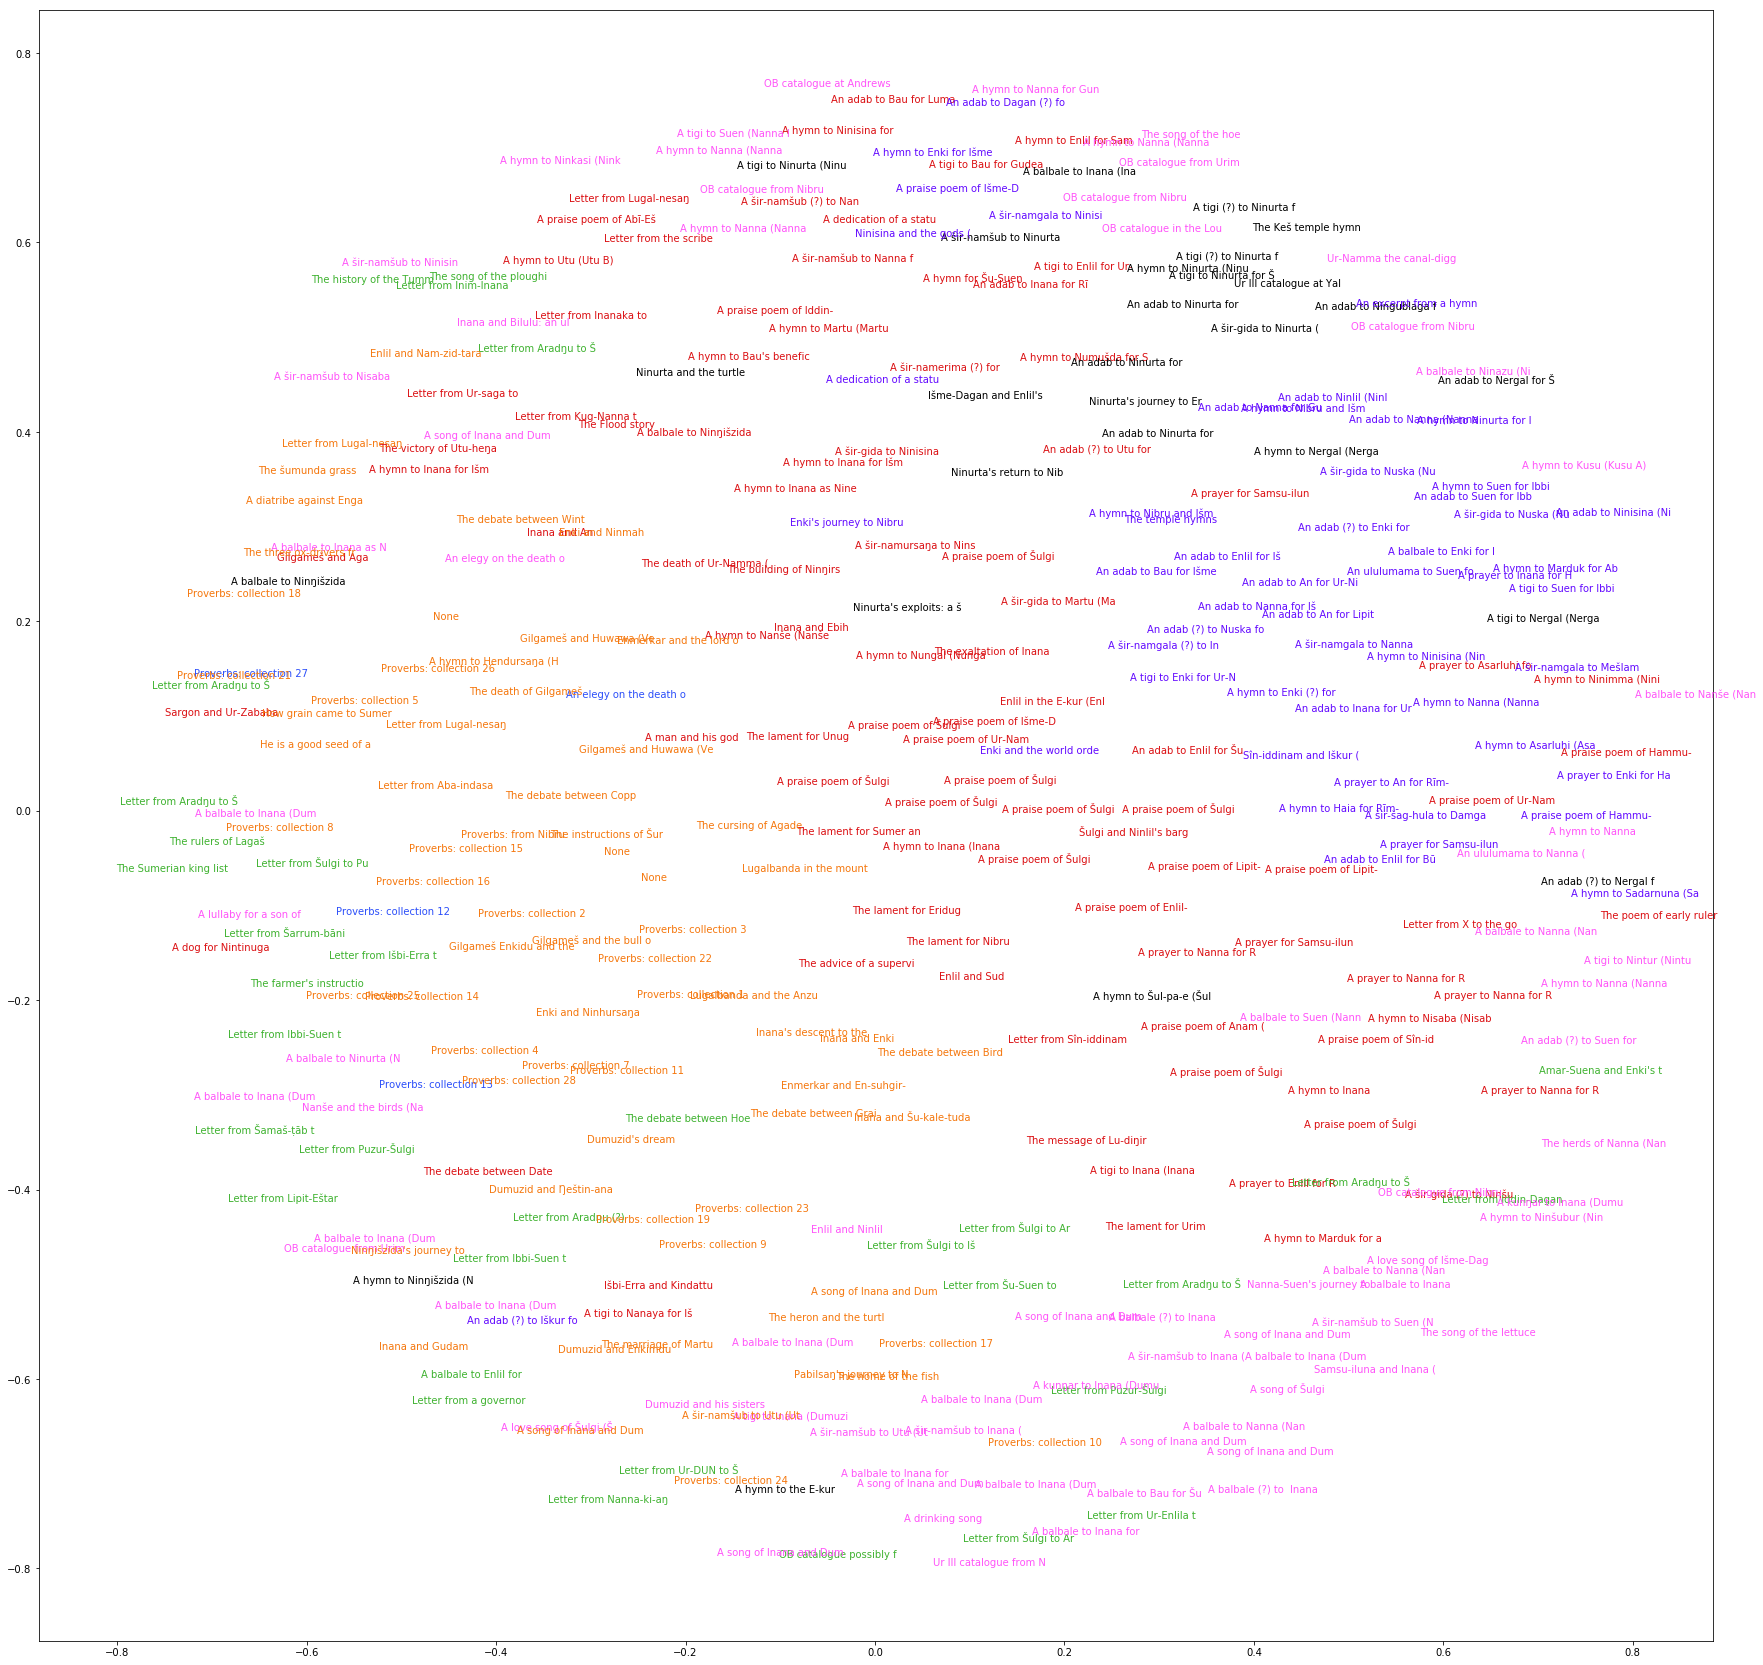

In [136]:
mds_cluster = MDS(n_components = 2, dissimilarity="precomputed")  #use MDS
embeddings_cluster = mds_cluster.fit_transform(dist_matrix) #the points/vectors of the texts obtained by MDS


data = {} #Match the text id to their data (may use for further analysis)

# Specify plot size and type
_, ax = plt.subplots(figsize=(30,30)) #plot
ax.scatter(embeddings_cluster[:,0], embeddings_cluster[:,1], alpha=0)


#Plot, Go through each cluster and match the cluster texts to their corresponding data from embeddings_cluster   
for i in range(len(cluster_0)):
    c = dict_color_cluster.get("cluster_0") 
    index = get_index(texts, cluster_0[i]) #find the index of the dist_matrix that matches the ith item in the cluster
    data[texts[index]] = [embeddings_cluster[index,0], embeddings_cluster[index,1]] #collect data
    ax.annotate(labels.get(cluster_0[i]), ((embeddings_cluster[index,0], embeddings_cluster[index,1])), color = c) #access and label the correct text i coordinates from embeddings_cluster

    
for i in range(len(cluster_1)):
    c = dict_color_cluster.get("cluster_1")
    index = get_index(texts, cluster_1[i])
    data[texts[index]] = [embeddings_cluster[index,0], embeddings_cluster[index,1]]
    ax.annotate(labels.get(cluster_1[i]), ((embeddings_cluster[index,0], embeddings_cluster[index,1])), color = c)
    
for i in range(len(cluster_2)):
    c = dict_color_cluster.get("cluster_2")
    index = get_index(texts, cluster_2[i])
    data[texts[index]] = [embeddings_cluster[index,0], embeddings_cluster[index,1]]
    ax.annotate(labels.get(cluster_2[i]), ((embeddings_cluster[index,0], embeddings_cluster[index,1])), color = c)
    
for i in range(len(cluster_3)):
    c = dict_color_cluster.get("cluster_3")
    index = get_index(texts, cluster_3[i])
    data[texts[index]] = [embeddings_cluster[index,0], embeddings_cluster[index,1]]
    ax.annotate(labels.get(cluster_3[i]), ((embeddings_cluster[index,0], embeddings_cluster[index,1])), color = c)
    
for i in range(len(cluster_4)):
    c = dict_color_cluster.get("cluster_4")
    index = get_index(texts, cluster_4[i])
    data[texts[index]] = [embeddings_cluster[index,0], embeddings_cluster[index,1]]
    ax.annotate(labels.get(cluster_4[i]), ((embeddings_cluster[index,0], embeddings_cluster[index,1])), color = c)
    
for i in range(len(cluster_5)):
    c = dict_color_cluster.get("cluster_5")
    index = get_index(texts, cluster_5[i])
    data[texts[index]] = [embeddings_cluster[index,0], embeddings_cluster[index,1]]
    ax.annotate(labels.get(cluster_5[i]), ((embeddings_cluster[index,0], embeddings_cluster[index,1])), color = c)
    
for i in range(len(cluster_6)):
    c = dict_color_cluster.get("cluster_6")
    index = get_index(texts, cluster_6[i])
    data[texts[index]] = [embeddings_cluster[index,0], embeddings_cluster[index,1]]
    ax.annotate(labels.get(cluster_6[i]), ((embeddings_cluster[index,0], embeddings_cluster[index,1])), color = c)


plt.show() #graphs the clusters by MDS 

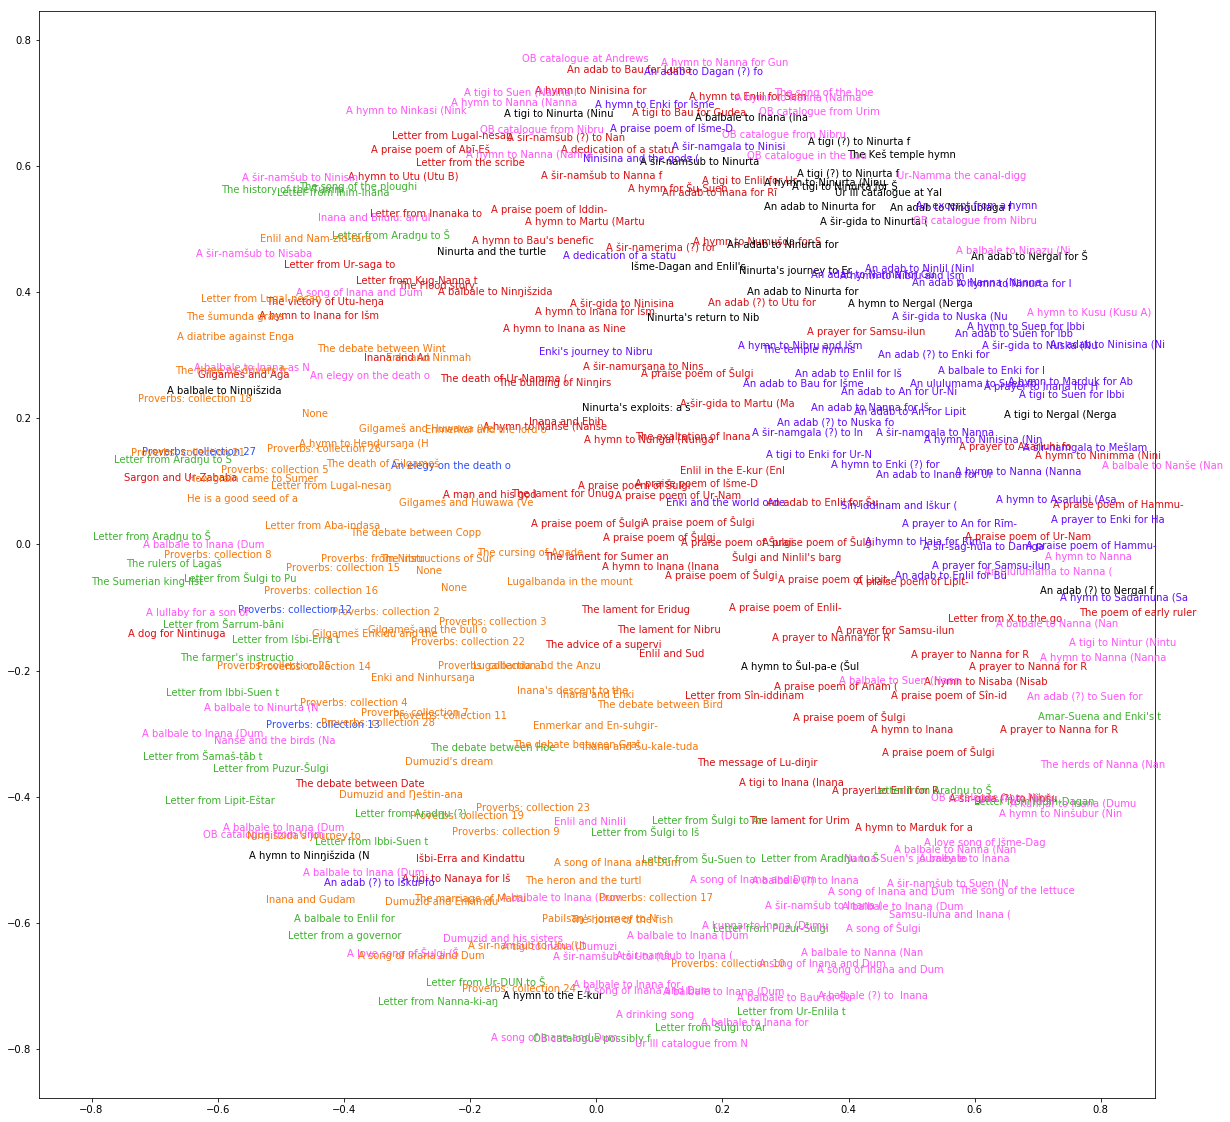

In [137]:
# Specify plot size and type (size is different from the previous graph)
_, ax = plt.subplots(figsize=(20,20)) #plot
ax.scatter(embeddings_cluster[:,0], embeddings_cluster[:,1], alpha=0)


#Plot, Go through each cluster and match the cluster texts to their corresponding data from embeddings_cluster   
for i in range(len(cluster_0)):
    c = dict_color_cluster.get("cluster_0") 
    index = get_index(texts, cluster_0[i]) #find the index of the dist_matrix that matches the ith item in cluster
    ax.annotate(labels.get(cluster_0[i]), ((embeddings_cluster[index,0], embeddings_cluster[index,1])), color = c) 
                            #access and label the correct text i coordinates from embeddings_cluster
    
for i in range(len(cluster_1)):
    c = dict_color_cluster.get("cluster_1")
    index = get_index(texts, cluster_1[i])
    ax.annotate(labels.get(cluster_1[i]), ((embeddings_cluster[index,0], embeddings_cluster[index,1])), color = c)
    
for i in range(len(cluster_2)):
    c = dict_color_cluster.get("cluster_2")
    index = get_index(texts, cluster_2[i])
    ax.annotate(labels.get(cluster_2[i]), ((embeddings_cluster[index,0], embeddings_cluster[index,1])), color = c)
    
for i in range(len(cluster_3)):
    c = dict_color_cluster.get("cluster_3")
    index = get_index(texts, cluster_3[i])
    ax.annotate(labels.get(cluster_3[i]), ((embeddings_cluster[index,0], embeddings_cluster[index,1])), color = c)
    
for i in range(len(cluster_4)):
    c = dict_color_cluster.get("cluster_4")
    index = get_index(texts, cluster_4[i])
    ax.annotate(labels.get(cluster_4[i]), ((embeddings_cluster[index,0], embeddings_cluster[index,1])), color = c)
    
for i in range(len(cluster_5)):
    c = dict_color_cluster.get("cluster_5")
    index = get_index(texts, cluster_5[i])
    ax.annotate(labels.get(cluster_5[i]), ((embeddings_cluster[index,0], embeddings_cluster[index,1])), color = c)
    
for i in range(len(cluster_6)):
    c = dict_color_cluster.get("cluster_6")
    index = get_index(texts, cluster_6[i])
    ax.annotate(labels.get(cluster_6[i]), ((embeddings_cluster[index,0], embeddings_cluster[index,1])), color = c)


plt.show() #graphs the clusters by MDS 

In [138]:
data #matched embeddings with text id

{'c.0.1.1': [0.060754096686954001, -0.79638034635210486],
 'c.0.1.2': [0.3789524064243896, 0.55331654738052105],
 'c.0.2.01': [0.19898610681848866, 0.64459838725876739],
 'c.0.2.02': [0.23951335828720943, 0.61178772786898539],
 'c.0.2.03': [-0.62377013891926492, -0.46566479752593054],
 'c.0.2.04': [0.25810183942649229, 0.68158062601279712],
 'c.0.2.06': [0.50267229066978902, 0.50800014388903292],
 'c.0.2.07': [-0.10087717058574569, -0.788603767289215],
 'c.0.2.08': [0.53070487889536544, -0.4062004159594515],
 'c.0.2.11': [-0.11700732780831712, 0.76529127096340044],
 'c.0.2.13': [-0.18425156486656183, 0.65254620763499249],
 'c.1.1.1': [-0.35745313566515674, -0.21567361878386312],
 'c.1.1.2': [-0.3334423105219711, 0.29030076047267589],
 'c.1.1.3': [0.11110118626091599, 0.060559542248286746],
 'c.1.1.4': [-0.089935994024318344, 0.30125352428035213],
 'c.1.2.1': [-0.067520097709954777, -0.44506962299355513],
 'c.1.2.2': [0.067790427867876896, -0.17856269780961334],
 'c.1.3.1': [-0.05790173

### End of Notebook